In [3]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.insert(1,'./../../../src')


import methods
import matplotlib.pyplot as plt
import networkx as nx
import scipy
import numpy as np
import betterspy

import qtree_methods as qtm

from sklearn.cluster import KMeans

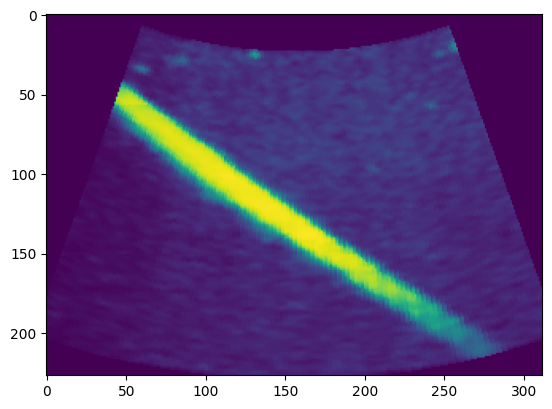

In [18]:
img_array, _ = methods.load('IMG_20240212_3_1_dp.nii.gz')


SLICE = 130
img_array = img_array[:,SLICE,:]
mask_array = img_array > 0

plt.imshow(img_array)
# plt.imshow(img_array[:,SLICE,:])

In [39]:
wf = methods.WeightKernel(
    dist_sig = 1,
    intensity_sig = 80
)

# problem with mask?
G = methods.ImageGraph(
    img_array, 
    mask_array=mask_array, 
    wf=wf, 
    neighbour_depth = 2, 
    cmap='viridis'
    )

In [40]:
G._create_zero_node(zero_node_threshold=50)

In [41]:
# nx.write_gexf(G, 'zero-node.gexf')

In [42]:
# nx.write_gexf(G, 'cow.gexf')

In [43]:
P = nx.normalized_laplacian_matrix(G)
N = P.shape[0]

In [44]:
print(N)
print(P.nnz/N**2)

54631
0.00026992680177882495


In [45]:
solve_matrix = -(P-scipy.sparse.identity(N))
# %timeit vals, vecs = scipy.sparse.linalg.eigs(solve_matrix, which='LM')
vals, vecs = scipy.sparse.linalg.eigs(solve_matrix, which='LR')

In [46]:
# %timeit vals, vecs = scipy.sparse.linalg.eigs(P, which='SR')

In [47]:
i = 4
eig_img = G._node_vec_to_img_array(np.real(vecs[:,i]))

skip


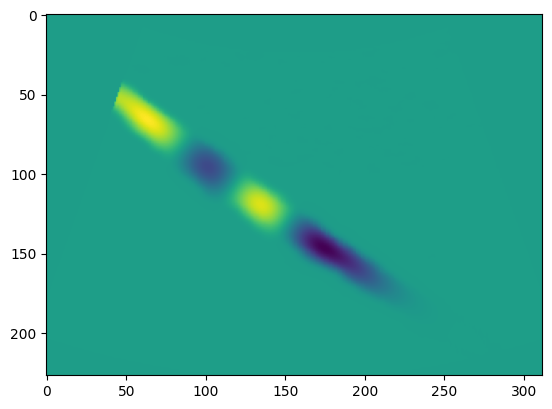

In [48]:
plt.imshow(eig_img[:,:])


/Users/jackh/opt/anaconda3/envs/gordon_original/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


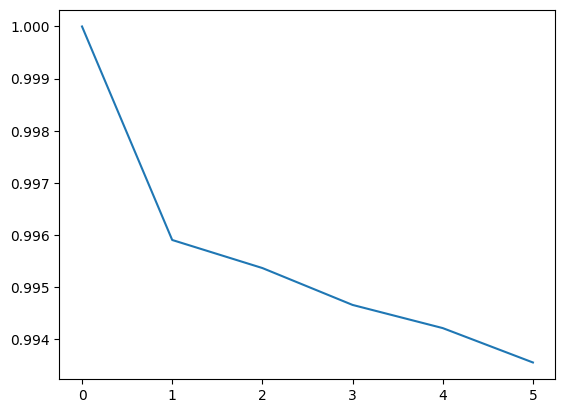

In [49]:
plt.plot(vals)

In [50]:
cluster_num = 5

kmeans = KMeans(n_clusters=cluster_num, random_state=0, n_init="auto").fit(np.real(vecs[:,:3]))
labels = kmeans.labels_+1

In [51]:
k_img = G._node_vec_to_img_array(labels)

skip


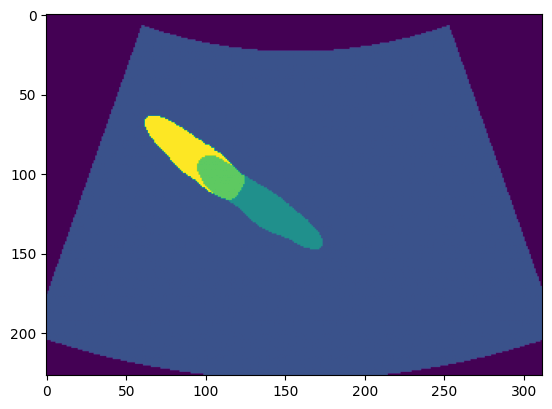

In [52]:
plt.imshow(k_img[:,:])

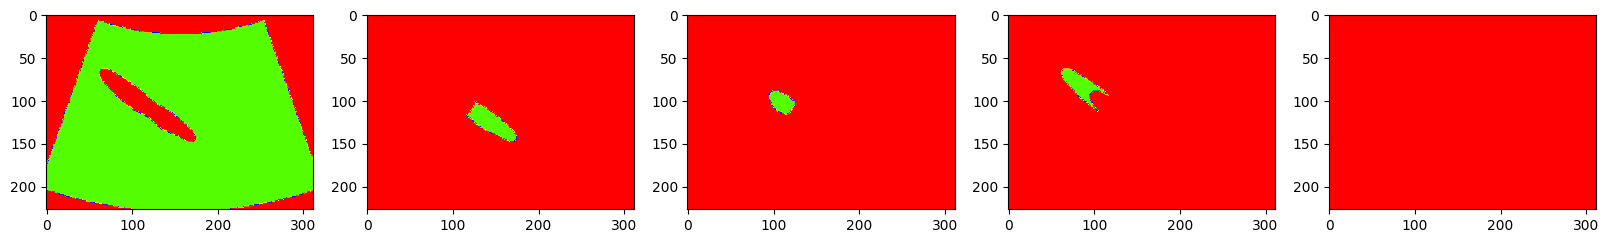

In [53]:

fig, axs = plt.subplots(1, cluster_num) 
fig.set_figheight(4)
fig.set_figwidth(20)

for i in range(1,cluster_num+1):
    curr = k_img == i
    axs[i-1].imshow(curr[:,:], cmap='prism')

In [54]:
S, R  = methods.SEBA(np.real(vecs)[:,:3])

In [55]:
seba_sum =  np.sum(S, axis=1)
seba_img = G._node_vec_to_img_array(seba_sum)

skip


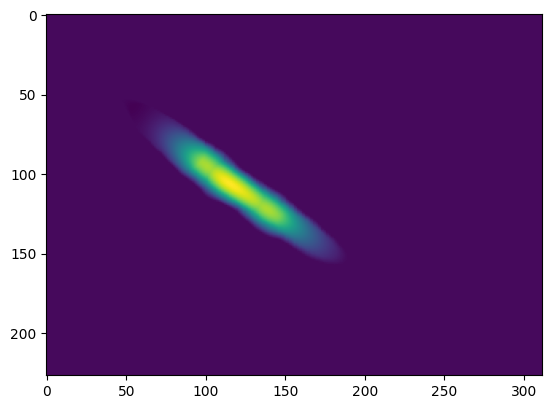

In [56]:
plt.imshow(seba_img[:,:])

skip


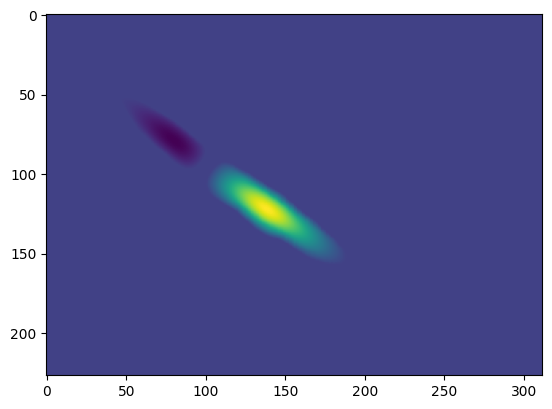

In [57]:
seba_component_img = G._node_vec_to_img_array(S[:,0])
plt.imshow(seba_component_img[:,:])

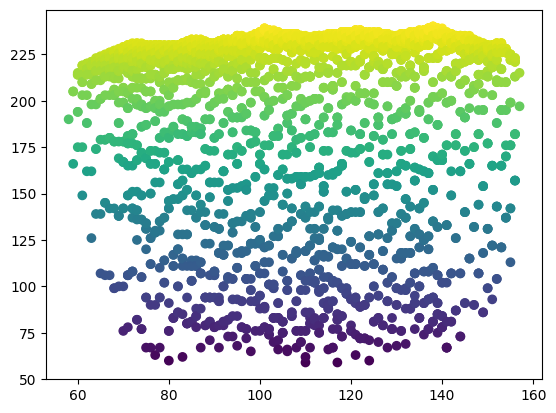

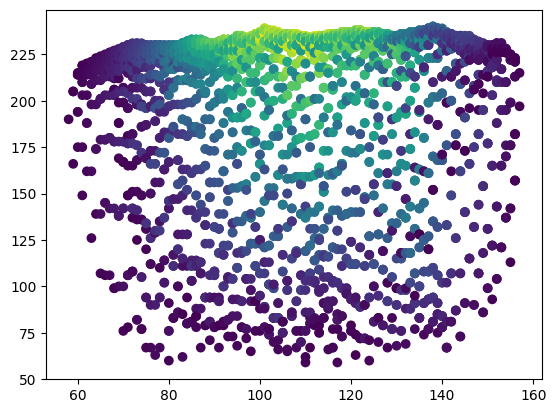

In [58]:
# TRACE DRAFT

def show_trace(img, mask = None, axis=0):
    if mask is None:
        mask = np.full(img.shape, True)
    
    # assert
    mask_color = mask

    mask_flat = (mask > 0).flatten()
    img_flat = img.flatten()
    mask_color_flat = mask_color.flatten()

    xys = np.meshgrid(range(img.shape[1]),range(img.shape[0]))
    
    d_flat = xys[axis].flatten()

    plt.figure()
    plt.scatter(d_flat[mask_flat], img_flat[mask_flat], c = img_flat[mask_flat])

    plt.figure()
    plt.scatter(d_flat[mask_flat], img_flat[mask_flat], c = mask_color_flat[mask_flat])


show_trace(img_array, mask = seba_img, axis=1)